Import Libraries

In [7]:
import pandas as pd
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error, mean_squared_log_error


Data preprocessing

Read data

In [8]:
df = pd.read_csv('Samsung_clean.csv')
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,1/4/2010,16060,16180,16000,16180,11978.36523,11950800
1,1/5/2010,16520,16580,16300,16440,12170.84668,27925850
2,1/6/2010,16580,16820,16520,16820,12452.17090,22948850
3,1/7/2010,16820,16820,16260,16260,12037.59082,22107950
4,1/8/2010,16400,16420,16120,16420,12156.04102,14777550


Reset index

In [9]:
# Convert 'Date' to datetime and set as index
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)

# Select the Close column as dependent variable
df_Close = df[['Close']].reset_index(drop=True)

Data normalization

In [10]:
# Min-max normalization
scaler = MinMaxScaler(feature_range=(0, 1))
data_scaled = scaler.fit_transform(np.array(df_Close))

Data splitting

In [11]:
# Split the data into training, validation and test dataset in a ratio of 7:1:2
train_size = int(0.7 * len(data_scaled))
val_size = int(0.1 * len(data_scaled))
test_size = len(data_scaled) - train_size - val_size

train_data = data_scaled[: train_size]
val_data = data_scaled[train_size : train_size + val_size]
test_data = data_scaled[train_size + val_size :]

Model training and testing

Training process

In [12]:
x_train = np.arange(train_size).reshape(-1, 1)
y_train = train_data.reshape(-1)

model = LinearRegression()
model.fit(x_train, y_train)

print("Intercept:", model.intercept_)
print("Coefficient:", model.coef_)
print("R²:", model.score(x_train, y_train))

Intercept: -0.021531670977345402
Coefficient: [0.00017998]
R²: 0.8137705311120516


Testing process

In [13]:
# Validation data
x_val = np.array(range(train_size, train_size + val_size)).reshape(-1, 1)
y_val = np.array(val_data).reshape(-1)
y_pred_val = model.predict(x_val)

# Evaluate
y_val_inv = scaler.inverse_transform(y_val.reshape(-1, 1))
y_pred_val_inv = scaler.inverse_transform(y_pred_val.reshape(-1, 1))

val_mape = mean_absolute_percentage_error(y_val_inv, y_pred_val_inv)
val_mse = mean_squared_error(y_val_inv, y_pred_val_inv)
val_rmse = np.sqrt(val_mse)
val_msle = mean_squared_log_error(y_val_inv, y_pred_val_inv)

print(f"MAPE (Validation): {val_mape}")
print(f"RMSE (Validation): {val_rmse}")
print(f"MSLE (Validation): {val_msle}")


MAPE (Validation): 0.2113287365094011
RMSE (Validation): 18651.069535028375
MSLE (Validation): 0.07599089291508271


In [14]:
# Test data
x_test = np.array(range(train_size + val_size, len(data_scaled))).reshape(-1, 1)
y_test = np.array(test_data).reshape(-1)
y_pred_test = model.predict(x_test)

# Evaluate
y_test_inv = scaler.inverse_transform(y_test.reshape(-1, 1))
y_pred_test_inv = scaler.inverse_transform(y_pred_test.reshape(-1, 1))

test_mape = mean_absolute_percentage_error(y_test_inv, y_pred_test_inv)
test_mse = mean_squared_error(y_test_inv, y_pred_test_inv)
test_rmse = np.sqrt(test_mse)
test_msle = mean_squared_log_error(y_test_inv, y_pred_test_inv)

print(f"MAPE (Test): {test_mape}")
print(f"RMSE (Test): {test_rmse}")
print(f"MSLE (Test): {test_msle}")


MAPE (Test): 0.12432208894542018
RMSE (Test): 9924.326139635104
MSLE (Test): 0.021560887117510388


Predicting the next 30 days

In [15]:
# Create index for next 30 days
last_index = df_Close.index[-1]
x_next_30_days = np.array(range(last_index + 1, last_index + 31)).reshape(-1, 1)

Preparing the prediction data

Prediction process

In [16]:
# Predict next 30 days
y_next_30_days = model.predict(x_next_30_days)
y_next_30_days_inv = scaler.inverse_transform(y_next_30_days.reshape(-1, 1))

print("Predicted closing prices for the next 30 days:")
print(y_next_30_days_inv.flatten())


Predicted closing prices for the next 30 days:
[73619.49580263 73635.40610467 73651.3164067  73667.22670874
 73683.13701077 73699.0473128  73714.95761484 73730.86791687
 73746.77821891 73762.68852094 73778.59882298 73794.50912501
 73810.41942704 73826.32972908 73842.24003111 73858.15033315
 73874.06063518 73889.97093721 73905.88123925 73921.79154128
 73937.70184332 73953.61214535 73969.52244739 73985.43274942
 74001.34305145 74017.25335349 74033.16365552 74049.07395756
 74064.98425959 74080.89456162]


Preparing the forecast date index

In [17]:
# Generate future date index
last_date = df.index[-1]
next_date = last_date + pd.DateOffset(days=1)
index_next_30_days = pd.date_range(start=next_date, periods=30).tolist()

Visualization

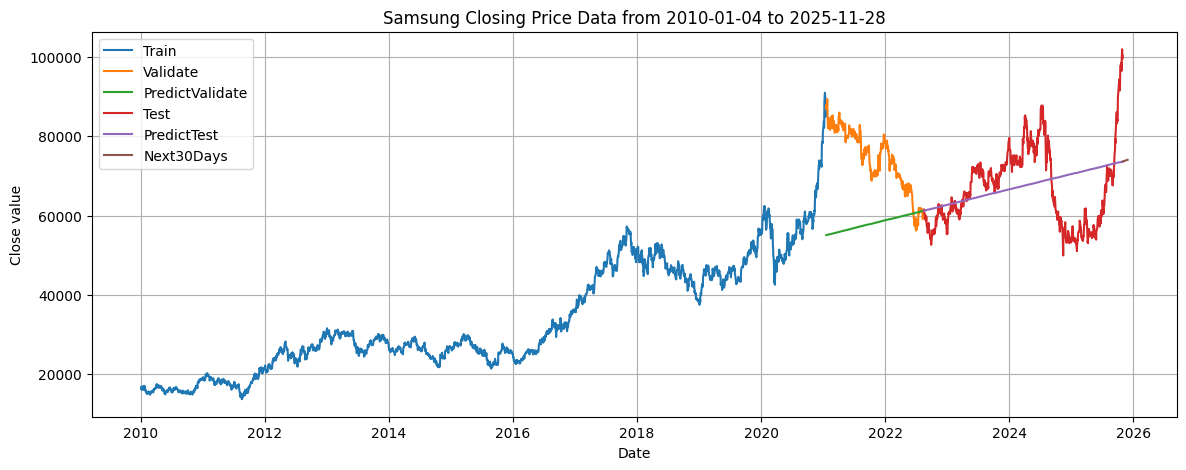

In [18]:
plt.figure(figsize=(14, 5))

plt.plot(df.index[:train_size], scaler.inverse_transform(y_train.reshape(-1, 1)))
plt.plot(df.index[train_size:train_size + val_size], y_val_inv)
plt.plot(df.index[train_size:train_size + val_size], y_pred_val_inv)
plt.plot(df.index[train_size + val_size:], y_test_inv)
plt.plot(df.index[train_size + val_size:], y_pred_test_inv)
plt.plot(index_next_30_days, y_next_30_days_inv)

plt.legend(['Train', 'Validate', 'PredictValidate', 'Test', 'PredictTest', 'Next30Days'])
plt.grid()
plt.title(f"Samsung Closing Price Data from {df.index[0].strftime('%Y-%m-%d')} to {index_next_30_days[-1].strftime('%Y-%m-%d')}")
plt.xlabel("Date")
plt.ylabel("Close value")
plt.savefig('LR_712_Samsung.png')
plt.show()
